<a href="https://colab.research.google.com/github/Nam25081108/Nghiencuukhoahoc/blob/main/Multivariate_PM25_MultiValue_case2_smoothing_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn import metrics
import logging
import os
import sys
from cgi import test
from glob import glob
from pydoc import describe
import numpy as np
import pandas as pd
from joblib import dump, load
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import (
    BayesianRidge,
    ElasticNet,
    LinearRegression,
    SGDRegressor,
)
from sklearn.model_selection import train_test_split
from sklearn.multioutput import RegressorChain
# from sklearnex import patch_sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVR
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Input, Dense, LSTM, Conv1D, Dropout, Bidirectional, Multiply
from tensorflow.keras.layers import InputLayer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [2]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [4]:
df_pre = pd.read_csv('Risk_2_MA_is_2_SV.csv', sep=",", dtype=str)
df_pre = df_pre[['PM2.5_s','wd_s','ws_s','Rainfall_s','lowleaf_s','temp_s','uvb_s']]
df_pre.head()

,PM2.5_s,wd_s,ws_s,Rainfall_s,lowleaf_s,temp_s,uvb_s
0,24.33,349.33,1.37,0.00,1.92,296.92,0.00
1,27.33,341.67,1.37,0.00,1.92,296.40,0.00
2,31.33,342.00,1.40,0.00,1.92,295.95,0.00
3,33.00,346.33,1.33,0.00,1.92,295.94,4580.61
4,36.67,245.00,1.20,0.00,1.92,296.41,29870.49


In [5]:
values = df_pre.values
# ensure all data is float
values = values.astype('float32')
temp = pd.DataFrame(values)
temp.head()

,0,1,2,3,4,5,6
0,24.330000,349.329987,1.37,0.0,1.92,296.920013,0.000000
1,27.330000,341.670013,1.37,0.0,1.92,296.399994,0.000000
2,31.330000,342.000000,1.40,0.0,1.92,295.950012,0.000000
3,33.000000,346.329987,1.33,0.0,1.92,295.940002,4580.609863
4,36.669998,245.000000,1.20,0.0,1.92,296.410004,29870.490234


In [6]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [7]:
#Box plot
#pd.options.display.mpl_style = False
#DataFrame(scaled).boxplot()
#dataset_columns = df_pre.columns.tolist()
#dataset_columns

In [8]:
#Single timestep no scale
# frame as supervised learning
n_hours = 6   # change timestep for comparison


n_features = 7
reframed = series_to_supervised(scaled, n_hours, 1)  # apply scaled not values
reframed.head()

,var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),var6(t-6),var7(t-6),var1(t-5),var2(t-5),var3(t-5),...,var5(t-1),var6(t-1),var7(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t)
6,0.152534,0.971198,0.183261,0.0,0.466667,0.222088,0.000000,0.172148,0.949861,0.183261,...,0.466667,0.274557,0.185934,0.174371,0.107688,0.115440,0.0,0.466667,0.367296,0.368548
7,0.172148,0.949861,0.183261,0.0,0.466667,0.190359,0.000000,0.198300,0.950780,0.187590,...,0.466667,0.367296,0.368548,0.156914,0.085404,0.096681,0.0,0.466667,0.458206,0.557556
8,0.198300,0.950780,0.187590,0.0,0.466667,0.162905,0.000000,0.209219,0.962841,0.177489,...,0.466667,0.458206,0.557556,0.165610,0.332396,0.076479,0.0,0.466667,0.529591,0.705831
9,0.209219,0.962841,0.177489,0.0,0.466667,0.162294,0.010598,0.233213,0.680585,0.158730,...,0.466667,0.529591,0.705831,0.189604,0.578440,0.057720,0.0,0.466667,0.593655,0.781249
10,0.233213,0.680585,0.158730,0.0,0.466667,0.190971,0.069108,0.198300,0.399248,0.139971,...,0.466667,0.593655,0.781249,0.226675,0.733510,0.033189,0.0,0.466667,0.640635,0.747778


In [9]:
# split into train and test sets
values = reframed.values
n_train_hours = 32469  # het nam 2021
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]   # test dau nam 2022 den 2023

In [10]:
# split into input and outputs
n_obs = n_hours * n_features
print(n_obs)
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)


42
(32469, 42) 32469 (32469,)


In [11]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(32469, 6, 7) (32469,) (11135, 6, 7) (11135,)


In [12]:

nsamples, nx, ny = train_X.shape
train_X = train_X.reshape((nsamples,nx*ny))


model = RandomForestRegressor()   # change models !  here !!!


model.fit(train_X, train_y)

RandomForestRegressor()

In [14]:
orginal_test_X = test_X.copy()
nsamples, nx, ny = orginal_test_X.shape
orginal_test_X = orginal_test_X.reshape((nsamples,nx*ny))
# make a prediction
yhat = model.predict(orginal_test_X)


In [15]:
yhat = yhat.reshape(1,-1).T
print(yhat.shape)

(11135, 1)


In [16]:
test_X = orginal_test_X.reshape((test_X.shape[0], n_hours*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -(n_features-1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -(n_features-1):]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]


In [17]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.4f' % rmse)

#calculate MAE
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.4f' % mae)

# r-squared score of the model
r2 = r2_score(inv_y, inv_yhat)
print('Test R2: %.4f'% r2)

Test RMSE: 3.3275
Test MAE: 2.3201
Test R2: 0.9283


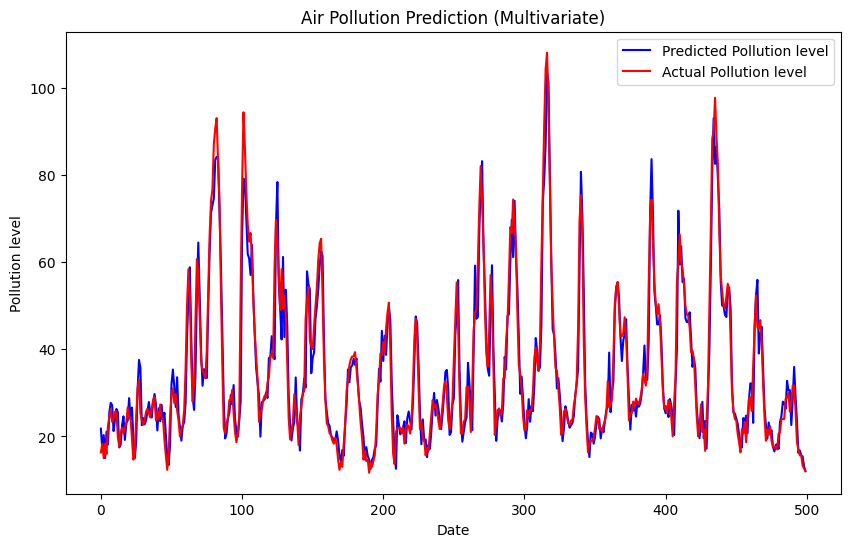

<Figure size 640x480 with 0 Axes>

In [18]:
#Plot the graph between actual vs predicted values
plt.figure(figsize=(10,6))
plt.plot(inv_yhat[:500], color= 'blue',label = 'Predicted Pollution level')
plt.plot(inv_y[:500] , color = 'red',label = 'Actual Pollution level')
plt.title("Air Pollution Prediction (Multivariate)")
plt.xlabel("Date")
plt.ylabel("Pollution level")
plt.legend()
plt.show()
plt.savefig('graph.png')

In [19]:
#write files
DataFrame([inv_y,inv_yhat]).T

,0,1
0,16.330000,21.786801
1,18.330000,16.962900
2,15.000000,20.307300
3,18.330000,15.031700
4,16.000000,21.092100
...,...,...
11130,12.670000,12.439300
11131,13.000001,13.382900
11132,13.670000,13.984900
11133,15.000000,13.877500


In [20]:



#write files
#output = DataFrame([inv_y,inv_yhat]).T
#output.columns = ['actual','predicted']
#output.to_csv("PM25_prediction_"+"timestep_"+str(n_hours)+".csv")


In [21]:
'''
 # model = SVR(kernel='rbf',gamma=0.5, C=10, epsilon = 0.05)
'''

"\n # model = SVR(kernel='rbf',gamma=0.5, C=10, epsilon = 0.05)\n"